# Clickbait Spoiling


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


###**1.1 Installing necessary libraries -**###


1. NLTK -> It provides powerfull text processing tools.

2. Scikit-learn -> It is used for Machine learning models and evaluation matrics.

3. Pandas -> It helps in loading and manipulating of datasets

In [ ]:
!pip install scikit-learn
!pip install pandas
!pip install nltk

import pandas as pd
import numpy as np
import re
import string
import nltk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import confusion_matrix

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer


import matplotlib.pyplot as plt
import seaborn as sns


from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier



In [ ]:
# Load dataseet into pandas dataframes
train_data = pd.read_json("/content/drive/MyDrive/NLP assingment/train.jsonl",lines=True)
val_data = pd.read_json("/content/drive/MyDrive/NLP assingment/validation.jsonl", lines=True)

In [ ]:
# Download NLTK resources
nltk.download("all")              # Including, stopwords, Punkt, Wordnet,etc.

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_rus to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |  

True

### 1.2  Analyse data
 Before processing check whats inside the data and look for important columns.

In [ ]:
# As we have our target variable "tags" we count each type of tag
tag_count = train_data["tags"].value_counts()
print("\nTag Distribution:\n", tag_count)


Tag Distribution:
 tags
[phrase]     1367
[passage]    1274
[multi]       559
Name: count, dtype: int64


<ipython-input-58-0aaecfc1c609>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tag_count.index, y=tag_count.values, palette="viridis")


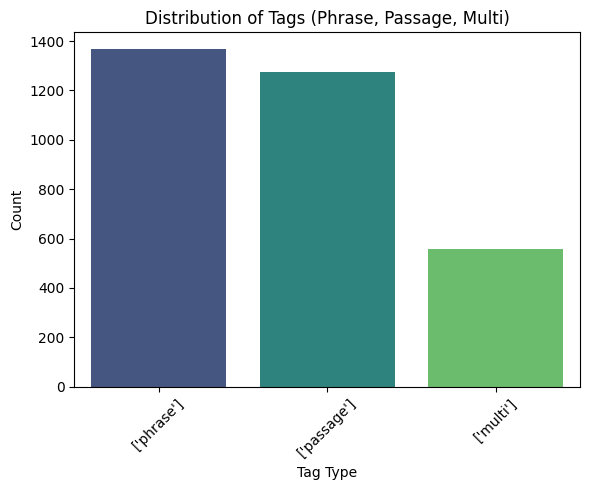

In [ ]:
# Convert the index of tag_count to strings
tag_count.index = tag_count.index.astype(str)

# Create a bar chart to see different tags in our data

plt.figure(figsize=(6,5))
sns.barplot(x=tag_count.index, y=tag_count.values, palette="viridis")
plt.xlabel("Tag Type")
plt.ylabel("Count")
plt.title("Distribution of Tags (Phrase, Passage, Multi)")
plt.xticks(rotation=45)                                       # Make labels easier to read
plt.tight_layout()                                            # Avoid text getting cut off
plt.show()

- From the above data, we can analyse that our dataset has nearly half of the "multi" spoiler type as compared to "phrase" and "passage" It can impact the accuracy.

In [ ]:
train_data.head()

,uuid,postId,postText,postPlatform,targetParagraphs,targetTitle,targetDescription,targetKeywords,targetMedia,targetUrl,provenance,spoiler,spoilerPositions,tags
0,0af11f6b-c889-4520-9372-66ba25cb7657,532quh,"[Wes Welker Wanted Dinner With Tom Brady, But ...",reddit,[It’ll be just like old times this weekend for...,"Wes Welker Wanted Dinner With Tom Brady, But P...",It'll be just like old times this weekend for ...,"new england patriots, ricky doyle, top stories,","[http://pixel.wp.com/b.gif?v=noscript, http://...",http://nesn.com/2016/09/wes-welker-wanted-dinn...,"{'source': 'anonymized', 'humanSpoiler': 'They...",[how about that morning we go throw?],"[[[3, 151], [3, 186]]]",[passage]
1,b1a1f63d-8853-4a11-89e8-6b2952a393ec,411701128456593408,[NASA sets date for full recovery of ozone hole],Twitter,[2070 is shaping up to be a great year for Mot...,Hole In Ozone Layer Expected To Make Full Reco...,2070 is shaping up to be a great year for Moth...,"ozone layer,ozone hole determined by weather,M...",[http://s.m.huffpost.com/assets/Logo_Huffingto...,http://huff.to/1cH672Z,"{'source': 'anonymized', 'humanSpoiler': '2070...",[2070],"[[[0, 0], [0, 4]]]",[phrase]
2,008b7b19-0445-4e16-8f9e-075b73f80ca4,380537005123190784,[This is what makes employees happy -- and it'...,Twitter,"[Despite common belief, money isn't the key to...",Intellectual Stimulation Trumps Money For Empl...,By: Chad Brooks \r\nPublished: 09/18/2013 06:4...,"employee happiness money,employee happiness in...",[http://i.huffpost.com/gen/1359674/images/o-HA...,http://huff.to/1epfeaw,"{'source': 'anonymized', 'humanSpoiler': 'Inte...",[intellectual stimulation],"[[[1, 186], [1, 210]]]",[phrase]
3,31ecf93c-3e21-4c80-949b-aa549a046b93,844567852531286016,[Passion is overrated — 7 work habits you need...,Twitter,"[It’s common wisdom. Near gospel really, and n...","‘Follow your passion’ is wrong, here are 7 hab...",There's a lot more to work that loving your job,"business, work-life, careers",None,None,"{'source': 'anonymized', 'humanSpoiler': None,...",[Purpose connects us to something bigger and i...,"[[[11, 25], [11, 101]], [[17, 56], [17, 85]], ...",[multi]
4,31b108a3-c828-421a-a4b9-cf651e9ac859,814186311573766144,[The perfect way to cook rice so that it's per...,Twitter,"[Boiling rice may seem simple, but there is a ...",Revealed: The perfect way to cook rice so that...,The question 'How does one cook rice properly?...,"Quora,users,share,perfect,way,cook,rice",None,None,"{'source': 'anonymized', 'humanSpoiler': None,...",[in a rice cooker],"[[[5, 60], [5, 76]]]",[phrase]


In [ ]:
# Check dataset structure
print(train_data.head())

                                   uuid              postId  \
0  0af11f6b-c889-4520-9372-66ba25cb7657              532quh   
1  b1a1f63d-8853-4a11-89e8-6b2952a393ec  411701128456593408   
2  008b7b19-0445-4e16-8f9e-075b73f80ca4  380537005123190784   
3  31ecf93c-3e21-4c80-949b-aa549a046b93  844567852531286016   
4  31b108a3-c828-421a-a4b9-cf651e9ac859  814186311573766144   

                                            postText postPlatform  \
0  [Wes Welker Wanted Dinner With Tom Brady, But ...       reddit   
1   [NASA sets date for full recovery of ozone hole]      Twitter   
2  [This is what makes employees happy -- and it'...      Twitter   
3  [Passion is overrated — 7 work habits you need...      Twitter   
4  [The perfect way to cook rice so that it's per...      Twitter   

                                    targetParagraphs  \
0  [It’ll be just like old times this weekend for...   
1  [2070 is shaping up to be a great year for Mot...   
2  [Despite common belief, money isn't

In [ ]:
# Check dataset columns
print(train_data.columns)

Index(['uuid', 'postId', 'postText', 'postPlatform', 'targetParagraphs',
       'targetTitle', 'targetDescription', 'targetKeywords', 'targetMedia',
       'targetUrl', 'provenance', 'spoiler', 'spoilerPositions', 'tags'],
      dtype='object')


In [ ]:
# For random rows
train_data.sample(5)

,uuid,postId,postText,postPlatform,targetParagraphs,targetTitle,targetDescription,targetKeywords,targetMedia,targetUrl,provenance,spoiler,spoilerPositions,tags
2895,d6742669-4d66-41c8-94c2-d2deafc95de2,386176103208873984,"[""Spider-Man"" star slams reboot movies]",Twitter,"[Willem Dafoe is not a fan of Sony's ""Spider-M...",Willem Dafoe Slams 'The Amazing Spider-Man' As...,"Willem Dafoe is not a fan of Sony's ""Spider-Ma...","willem dafoe the amazing spider-man,video,The ...",[http://s.m.huffpost.com/assets/Logo_Huffingto...,http://huff.to/1bDUokc,"{'source': 'anonymized', 'humanSpoiler': 'Star...",[Willem Dafoe],"[[[0, 0], [0, 12]]]",[phrase]
399,95e64dbe-8d24-45f9-ac06-1039782a483e,389744968765812736,[Bill Murray may join Cameron Crowe's new movie],Twitter,[Cameron Crowe's new movie may also feature a ...,Bill Murray May Join Cameron Crowe's New Movie,Cameron Crowe's new movie may also feature a l...,"bill murray cameron crowe movie,deep tiki,Dann...",[http://i.huffpost.com/gen/1404907/images/o-BI...,http://huff.to/1ck3cfr,"{'source': 'anonymized', 'humanSpoiler': 'Or m...","[That's the word from TheWrap, which reports t...","[[[0, 65], [0, 179]]]",[passage]
755,fe58fc73-a128-4877-b5d8-de156aba3b3e,51mxc6,[15 Crazy World of Warcraft Facts That Will Im...,reddit,[Vin Diesel and Paul Walker played World of Wa...,https://www.gamespot.com/gallery/18-crazy-worl...,From game-playing celebrities to a dying fan's...,None,[http://archive.is/oXerr/3cedcb895fafb77860a25...,http://archive.is/oXerr,"{'source': 'anonymized', 'humanSpoiler': 'All ...",[Vin Diesel and Paul Walker played World of Wa...,"[[[0, 0], [0, 61]], [[3, 0], [3, 36]], [[6, 0]...",[multi]
2375,595a2a35-bbc7-4ed9-a163-48d5f5447385,464043888450105345,[@JTimberlake reveals which hit *NSYNC song wa...,Twitter,[*NSYNC fans should be interested to learn tha...,Justin Timberlake Wrote *NSYNC's 'Gone' For Mi...,*NSYNC fans should be interested to learn that...,"justin timberlake gone,justin timberlake nsync...",[http://s.m.huffpost.com/assets/Logo_Huffingto...,http://huff.to/1jyID3C,"{'source': 'anonymized', 'humanSpoiler': '""Gon...","[""Gone""]","[[[1, 190], [1, 196]]]",[phrase]
701,d00a028c-0ce4-4b07-b815-edc279f1fe62,51lp5g,[They Found A Secret Trapdoor In Their House -...,reddit,"[When moving into a new house, Imgur user Czar...",They Found A Secret Trapdoor In Their House - ...,When they found a mysterious trapdoor in their...,"man finds hidden box in new house, hidden box ...","[data:image/gif;base64,R0lGODlhAQABAIAAANvf7wA...",http://archive.is/mU34z,"{'source': 'anonymized', 'humanSpoiler': 'A lo...",[little treasure chest],"[[[14, 17], [14, 38]]]",[phrase]


From the above samples, we got to know that the *key columns*  are *postText:* That has Clickbait post, *targetParagraphs:* It has Content from the linked article, and *tags:* Which specify Spoiler type is  phrase, passage, multi.




### 1.3 Text preprocessing -
- (1) Null values
- (2) Lowercasing
- (3) Removing special characters & punctuation
- (4)Tokenization     
- (5)Removing stopwords like "and", "the", etc
- (6)Lemmatization/Stemming
- (7) Removing extra whitespaces


In [ ]:
# Check for missing values
print(train_data.isnull().sum())

uuid                    0
postId                  0
postText                0
postPlatform            0
targetParagraphs        0
targetTitle             0
targetDescription     267
targetKeywords       1084
targetMedia           515
targetUrl             483
provenance              0
spoiler                 0
spoilerPositions        0
tags                    0
dtype: int64


In [ ]:
# Fill missing values with empty, it is better than removing them
train_data.fillna("", inplace=True)

In [ ]:
# Again check for null values
print(train_data.isnull())

       uuid  postId  postText  postPlatform  targetParagraphs  targetTitle  \
0     False   False     False         False             False        False   
1     False   False     False         False             False        False   
2     False   False     False         False             False        False   
3     False   False     False         False             False        False   
4     False   False     False         False             False        False   
...     ...     ...       ...           ...               ...          ...   
3195  False   False     False         False             False        False   
3196  False   False     False         False             False        False   
3197  False   False     False         False             False        False   
3198  False   False     False         False             False        False   
3199  False   False     False         False             False        False   

      targetDescription  targetKeywords  targetMedia  targetUrl

In [ ]:
print(train_data.isnull().sum())

uuid                 0
postId               0
postText             0
postPlatform         0
targetParagraphs     0
targetTitle          0
targetDescription    0
targetKeywords       0
targetMedia          0
targetUrl            0
provenance           0
spoiler              0
spoilerPositions     0
tags                 0
dtype: int64


Null values handled, now Lowercasing After considering the importance of the columns for the task.

#### 1.3 (1) Lowercasing

In [ ]:
# Lowercasing both the columns
train_data["postText"] = train_data["postText"].apply(lambda x: x.lower() if isinstance(x, str) else x)
train_data["spoiler"] = train_data["spoiler"].apply(lambda x: x.lower() if isinstance(x, str) else x)


In [ ]:
train_data.sample(5)

,uuid,postId,postText,postPlatform,targetParagraphs,targetTitle,targetDescription,targetKeywords,targetMedia,targetUrl,provenance,spoiler,spoilerPositions,tags
257,4a13f5b6-b8f7-47f2-9a00-3e65f3dc515c,409854567472726016,[You'll never guess what was being smuggled in...,Twitter,"[Step away from the toothpaste boxes!, A trio ...",You'll Never Guess What Was Being Smuggled In ...,Step away from the toothpaste boxes!\r\n\r\nA ...,"Green News,Bird Smuggling Toothpaste Boxes,Bir...",[http://i.huffpost.com/gen/1494939/thumbs/o-BI...,http://huff.to/1eWs8L9,"{'source': 'anonymized', 'humanSpoiler': 'Exot...",[exotic birds],"[[[1, 46], [1, 58]]]",[phrase]
346,9b876131-8ff1-44ec-b88b-7cc39db3d537,4nakaz,[‘It’s Something I’m Still Processing’: Hillar...,reddit,[A day after claiming her party’s nomination f...,‘It’s Something I’m Still Processing’: Hillary...,A day after claiming the Democratic presidenti...,"Clinton Hillary Rodham,Presidential Election ...",[http://archive.is/x1nzu/cda918ec817723362b140...,http://archive.is/x1nzu,"{'source': 'anonymized', 'humanSpoiler': 'Poli...",[personal attacks],"[[[6, 245], [6, 261]]]",[phrase]
385,db905c6c-4d9e-4509-98ee-1146336c8f3a,809405262889095168,[Their parents #disappeared at the railway sta...,Twitter,"[At the age of 11, Pradeep was brought to Pune...","Parents Abandon Kids At Railway Station, A Pol...","Parents Abandon Kids At Railway Station, A Pol...","Kids Railway Station, Policeman station",,,"{'source': 'anonymized', 'humanSpoiler': None,...",[Parents Abandon Kids At Railway Station],"[[[-1, 0], [-1, 39]]]",[passage]
2899,e8858daf-08ec-4aa4-867c-76ccdab06016,826870784283013121,"[They resisted so hard and got so far, but in ...",Twitter,"[Nearly a majority of voters, 49 percent, appr...",Poll: 49 Percent Approve of the Job Trump Is D...,Poll: 49 Percent Approve of the Job Trump Is D...,"Donald Trump,Big Government,trump",,,"{'source': 'anonymized', 'humanSpoiler': None,...","[Nearly a majority of voters, 49 percent, appr...","[[[0, 0], [0, 132]]]",[passage]
2389,ae7c37b7-09d1-4fd5-a52b-9ee3cd97a5ed,4sv09i,[I Made These Changes to How I Grocery Shop an...,reddit,"[Listen, we both know that you could be saving...",I Made These Changes to How I Grocery Shop and...,,"ways to save money, advertising",[http://archive.is/Xs31d/d1ad2760f5ddaa1cc046e...,http://archive.is/Xs31d,"{'source': 'anonymized', 'humanSpoiler': 'most...",[Nielsen company will pay you to scan your gro...,"[[[3, 22], [3, 73]], [[8, 0], [8, 48]], [[16, ...",[multi]


The above code for lowercasing have not worked because our data in "postText" and "spoiler" is in list if it was in str then it was supposed to work. so to handel list ddata we are going to define a function name "lowercase".

In [ ]:
# Apply function in both postText column and spoiler column.
# I have taken only postText, tags, spoiler for improving accquracy.
train_data["postText"] = train_data["postText"].apply(lambda x: " ".join(x) if isinstance(x, list) else str(x))
train_data["spoiler"] = train_data["spoiler"].apply(lambda x: " ".join(x) if isinstance(x, list) else str(x))
"""train_data["targetParagraphs"] = train_data["targetParagraphs"].apply(lambda x: " ".join(x) if isinstance(x, list) else str(x))
train_data["targetTitle"] = train_data["targetTitle"].apply(lambda x: " ".join(x) if isinstance(x, list) else str(x))
train_data["targetDescription"] = train_data["targetDescription"].apply(lambda x: " ".join(x) if isinstance(x, list) else str(x))"""
train_data["tags"] = train_data["tags"].apply(lambda x: " ".join(x) if isinstance(x, list) else str(x))

# Now apply lowercasing
train_data["postText"] = train_data["postText"].str.lower()
train_data["spoiler"] = train_data["spoiler"].str.lower()
"""train_data["targetParagraphs"] = train_data["targetParagraphs"].str.lower()
train_data["targetTitle"] = train_data["targetTitle"].str.lower()
train_data["targetDescription"] = train_data["targetDescription"].str.lower()"""
train_data["tags"] = train_data["tags"].str.lower()

# Verify changes
print(train_data[["postText", "spoiler",'tags']].head(5))

                                            postText  \
0  wes welker wanted dinner with tom brady, but p...   
1     nasa sets date for full recovery of ozone hole   
2  this is what makes employees happy -- and it's...   
3  passion is overrated — 7 work habits you need ...   
4  the perfect way to cook rice so that it's perf...   

                                             spoiler     tags  
0                how about that morning we go throw?  passage  
1                                               2070   phrase  
2                           intellectual stimulation   phrase  
3  purpose connects us to something bigger and in...    multi  
4                                   in a rice cooker   phrase  


#### 1.3 (2) Removing special characters & punctuation by using either "re" or "string.punctuation".  

In [ ]:
# Removing special characters & punctuation by using "str"
symbols = '@#$%^&*()_=+[]{}|\\<>/~`'
all_special_chr_remove = string.punctuation + symbols
translator = str.maketrans("", "", all_special_chr_remove)

# Define a function to clean text
def clean_text(text):
  if isinstance(text,list):
    text.join(text)                    # It will convert list to string
  if isinstance(text,str):
    return text.translate(translator)  # It will remove all the special characters and punctuation


# Apply to all the important columns for subtask 1
col_to_clean = ["postText", "spoiler"]
for col in col_to_clean:
  train_data[col] = train_data[col].apply(clean_text)

In [ ]:
# Check for the desired result
print(train_data[["postText", "spoiler",'tags']].head(5))

                                            postText  \
0  wes welker wanted dinner with tom brady but pa...   
1     nasa sets date for full recovery of ozone hole   
2  this is what makes employees happy  and its no...   
3  passion is overrated — 7 work habits you need ...   
4  the perfect way to cook rice so that its perfe...   

                                             spoiler     tags  
0                 how about that morning we go throw  passage  
1                                               2070   phrase  
2                           intellectual stimulation   phrase  
3  purpose connects us to something bigger and in...    multi  
4                                   in a rice cooker   phrase  


After looking at the date in  column named targetDescription 3rd line 09/18/2013, It is certain that we have achieved the desired result and removed special characters & punctuation.

#### 1.3 (3) Tokenization

In [ ]:
# Define a function
def preprc_text(text):
    sentences = word_tokenize(text)  # Split into sentences

    return sentences

In [ ]:
# Apply to all the important columns for subtask 1
# I tokenize many for previous approches but i have taken   only postText for final.
#col_to_tokenize = ["postText", "spoiler", "targetParagraphs", "targetTitle", "targetDescription"]
"""train_data["targetParagraphs"] = train_data["targetParagraphs"].astype(str)
train_data["targetParagraphs"] = train_data["targetParagraphs"].apply(preprc_text)
"""
train_data["postText"] = train_data["postText"].astype(str)
train_data["postText"] = train_data["postText"].apply(preprc_text)

train_data["spoiler"] = train_data["spoiler"].astype(str)
train_data["spoiler"] = train_data["spoiler"].apply(preprc_text)

"""train_data["targetTitle"] = train_data["targetTitle"].astype(str)
train_data["targetTitle"] = train_data["targetTitle"].apply(preprc_text)

train_data["targetDescription"] = train_data["targetDescription"].astype(str)
train_data["targetDescription"] = train_data["targetDescription"].apply(preprc_text)"""


'train_data["targetTitle"] = train_data["targetTitle"].astype(str)\ntrain_data["targetTitle"] = train_data["targetTitle"].apply(preprc_text)\n\ntrain_data["targetDescription"] = train_data["targetDescription"].astype(str)\ntrain_data["targetDescription"] = train_data["targetDescription"].apply(preprc_text)'

In [ ]:
train_data.head()

,uuid,postId,postText,postPlatform,targetParagraphs,targetTitle,targetDescription,targetKeywords,targetMedia,targetUrl,provenance,spoiler,spoilerPositions,tags
0,0af11f6b-c889-4520-9372-66ba25cb7657,532quh,"[wes, welker, wanted, dinner, with, tom, brady...",reddit,[It’ll be just like old times this weekend for...,"Wes Welker Wanted Dinner With Tom Brady, But P...",It'll be just like old times this weekend for ...,"new england patriots, ricky doyle, top stories,","[http://pixel.wp.com/b.gif?v=noscript, http://...",http://nesn.com/2016/09/wes-welker-wanted-dinn...,"{'source': 'anonymized', 'humanSpoiler': 'They...","[how, about, that, morning, we, go, throw]","[[[3, 151], [3, 186]]]",passage
1,b1a1f63d-8853-4a11-89e8-6b2952a393ec,411701128456593408,"[nasa, sets, date, for, full, recovery, of, oz...",Twitter,[2070 is shaping up to be a great year for Mot...,Hole In Ozone Layer Expected To Make Full Reco...,2070 is shaping up to be a great year for Moth...,"ozone layer,ozone hole determined by weather,M...",[http://s.m.huffpost.com/assets/Logo_Huffingto...,http://huff.to/1cH672Z,"{'source': 'anonymized', 'humanSpoiler': '2070...",[2070],"[[[0, 0], [0, 4]]]",phrase
2,008b7b19-0445-4e16-8f9e-075b73f80ca4,380537005123190784,"[this, is, what, makes, employees, happy, and,...",Twitter,"[Despite common belief, money isn't the key to...",Intellectual Stimulation Trumps Money For Empl...,By: Chad Brooks \r\nPublished: 09/18/2013 06:4...,"employee happiness money,employee happiness in...",[http://i.huffpost.com/gen/1359674/images/o-HA...,http://huff.to/1epfeaw,"{'source': 'anonymized', 'humanSpoiler': 'Inte...","[intellectual, stimulation]","[[[1, 186], [1, 210]]]",phrase
3,31ecf93c-3e21-4c80-949b-aa549a046b93,844567852531286016,"[passion, is, overrated, —, 7, work, habits, y...",Twitter,"[It’s common wisdom. Near gospel really, and n...","‘Follow your passion’ is wrong, here are 7 hab...",There's a lot more to work that loving your job,"business, work-life, careers",,,"{'source': 'anonymized', 'humanSpoiler': None,...","[purpose, connects, us, to, something, bigger,...","[[[11, 25], [11, 101]], [[17, 56], [17, 85]], ...",multi
4,31b108a3-c828-421a-a4b9-cf651e9ac859,814186311573766144,"[the, perfect, way, to, cook, rice, so, that, ...",Twitter,"[Boiling rice may seem simple, but there is a ...",Revealed: The perfect way to cook rice so that...,The question 'How does one cook rice properly?...,"Quora,users,share,perfect,way,cook,rice",,,"{'source': 'anonymized', 'humanSpoiler': None,...","[in, a, rice, cooker]","[[[5, 60], [5, 76]]]",phrase


In [ ]:
# Stopword Removal
stop_words = set(stopwords.words("english"))

# Function to remove stopwords from a list of tokens
def remove_stopwords(tokens):
    return [word for word in tokens if word.lower() not in stop_words]

# Apply to each tokenized column
columns_to_clean = ["postText", "spoiler"]        # Removed these "targetParagraphs", "targetTitle", "targetDescription" to improve accquracy

for col in columns_to_clean:
    train_data[col] = train_data[col].apply(remove_stopwords)


In [ ]:
train_data.head()

,uuid,postId,postText,postPlatform,targetParagraphs,targetTitle,targetDescription,targetKeywords,targetMedia,targetUrl,provenance,spoiler,spoilerPositions,tags
0,0af11f6b-c889-4520-9372-66ba25cb7657,532quh,"[wes, welker, wanted, dinner, tom, brady, patr...",reddit,[It’ll be just like old times this weekend for...,"Wes Welker Wanted Dinner With Tom Brady, But P...",It'll be just like old times this weekend for ...,"new england patriots, ricky doyle, top stories,","[http://pixel.wp.com/b.gif?v=noscript, http://...",http://nesn.com/2016/09/wes-welker-wanted-dinn...,"{'source': 'anonymized', 'humanSpoiler': 'They...","[morning, go, throw]","[[[3, 151], [3, 186]]]",passage
1,b1a1f63d-8853-4a11-89e8-6b2952a393ec,411701128456593408,"[nasa, sets, date, full, recovery, ozone, hole]",Twitter,[2070 is shaping up to be a great year for Mot...,Hole In Ozone Layer Expected To Make Full Reco...,2070 is shaping up to be a great year for Moth...,"ozone layer,ozone hole determined by weather,M...",[http://s.m.huffpost.com/assets/Logo_Huffingto...,http://huff.to/1cH672Z,"{'source': 'anonymized', 'humanSpoiler': '2070...",[2070],"[[[0, 0], [0, 4]]]",phrase
2,008b7b19-0445-4e16-8f9e-075b73f80ca4,380537005123190784,"[makes, employees, happy, paycheck]",Twitter,"[Despite common belief, money isn't the key to...",Intellectual Stimulation Trumps Money For Empl...,By: Chad Brooks \r\nPublished: 09/18/2013 06:4...,"employee happiness money,employee happiness in...",[http://i.huffpost.com/gen/1359674/images/o-HA...,http://huff.to/1epfeaw,"{'source': 'anonymized', 'humanSpoiler': 'Inte...","[intellectual, stimulation]","[[[1, 186], [1, 210]]]",phrase
3,31ecf93c-3e21-4c80-949b-aa549a046b93,844567852531286016,"[passion, overrated, —, 7, work, habits, need,...",Twitter,"[It’s common wisdom. Near gospel really, and n...","‘Follow your passion’ is wrong, here are 7 hab...",There's a lot more to work that loving your job,"business, work-life, careers",,,"{'source': 'anonymized', 'humanSpoiler': None,...","[purpose, connects, us, something, bigger, mak...","[[[11, 25], [11, 101]], [[17, 56], [17, 85]], ...",multi
4,31b108a3-c828-421a-a4b9-cf651e9ac859,814186311573766144,"[perfect, way, cook, rice, perfectly, fluffy, ...",Twitter,"[Boiling rice may seem simple, but there is a ...",Revealed: The perfect way to cook rice so that...,The question 'How does one cook rice properly?...,"Quora,users,share,perfect,way,cook,rice",,,"{'source': 'anonymized', 'humanSpoiler': None,...","[rice, cooker]","[[[5, 60], [5, 76]]]",phrase


In [ ]:
train_data.columns

Index(['uuid', 'postId', 'postText', 'postPlatform', 'targetParagraphs',
       'targetTitle', 'targetDescription', 'targetKeywords', 'targetMedia',
       'targetUrl', 'provenance', 'spoiler', 'spoilerPositions', 'tags'],
      dtype='object')

In [ ]:
train_data.postText

,postText
0,"[wes, welker, wanted, dinner, tom, brady, patr..."
1,"[nasa, sets, date, full, recovery, ozone, hole]"
2,"[makes, employees, happy, paycheck]"
3,"[passion, overrated, —, 7, work, habits, need,..."
4,"[perfect, way, cook, rice, perfectly, fluffy, ..."
...,...
3195,"[facebooks, video, explosion, completely, shak..."
3196,"[cop, eating, chilis, teen, hands, folded, nap..."
3197,"[5, popular, myths, visible, signs, aging, bogus]"
3198,"[need, see, twitter, account, predicted, beyon..."


#### 1.3 (5)  Lemmatization

In [ ]:
# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Define a function to apply lemmatization

def process_with_lemmatization(content):
  if type(content) is list:                     # As above column like targetParagraph are in list format
    content = " ".join(content)                 # Convert lists to strings for processing

  if type(content) is str:
    word_list = content.split()                 # Break text into individual words


    root_words = []                            # Transform each word to its root form
    for word in word_list:
      root_words.append(lemmatizer.lemmatize(word))
    return " ".join(root_words)

  return content                                # Return original content if not processable



In [ ]:
# Apply function process_with_lemmatization on selected columns
# Removed these columns to improve accquracy  "targetParagraphs", "targetTitle", "targetDescription".
lem_col = ["postText", "spoiler", "tags"]

# Apply our lemmatization to each column

for col in lem_col:
  train_data[col] = train_data[col].apply(process_with_lemmatization)

In [ ]:
train_data.head()

,uuid,postId,postText,postPlatform,targetParagraphs,targetTitle,targetDescription,targetKeywords,targetMedia,targetUrl,provenance,spoiler,spoilerPositions,tags
0,0af11f6b-c889-4520-9372-66ba25cb7657,532quh,wes welker wanted dinner tom brady patriot qb ...,reddit,[It’ll be just like old times this weekend for...,"Wes Welker Wanted Dinner With Tom Brady, But P...",It'll be just like old times this weekend for ...,"new england patriots, ricky doyle, top stories,","[http://pixel.wp.com/b.gif?v=noscript, http://...",http://nesn.com/2016/09/wes-welker-wanted-dinn...,"{'source': 'anonymized', 'humanSpoiler': 'They...",morning go throw,"[[[3, 151], [3, 186]]]",passage
1,b1a1f63d-8853-4a11-89e8-6b2952a393ec,411701128456593408,nasa set date full recovery ozone hole,Twitter,[2070 is shaping up to be a great year for Mot...,Hole In Ozone Layer Expected To Make Full Reco...,2070 is shaping up to be a great year for Moth...,"ozone layer,ozone hole determined by weather,M...",[http://s.m.huffpost.com/assets/Logo_Huffingto...,http://huff.to/1cH672Z,"{'source': 'anonymized', 'humanSpoiler': '2070...",2070,"[[[0, 0], [0, 4]]]",phrase
2,008b7b19-0445-4e16-8f9e-075b73f80ca4,380537005123190784,make employee happy paycheck,Twitter,"[Despite common belief, money isn't the key to...",Intellectual Stimulation Trumps Money For Empl...,By: Chad Brooks \r\nPublished: 09/18/2013 06:4...,"employee happiness money,employee happiness in...",[http://i.huffpost.com/gen/1359674/images/o-HA...,http://huff.to/1epfeaw,"{'source': 'anonymized', 'humanSpoiler': 'Inte...",intellectual stimulation,"[[[1, 186], [1, 210]]]",phrase
3,31ecf93c-3e21-4c80-949b-aa549a046b93,844567852531286016,passion overrated — 7 work habit need instead,Twitter,"[It’s common wisdom. Near gospel really, and n...","‘Follow your passion’ is wrong, here are 7 hab...",There's a lot more to work that loving your job,"business, work-life, careers",,,"{'source': 'anonymized', 'humanSpoiler': None,...",purpose connects u something bigger make u rig...,"[[[11, 25], [11, 101]], [[17, 56], [17, 85]], ...",multi
4,31b108a3-c828-421a-a4b9-cf651e9ac859,814186311573766144,perfect way cook rice perfectly fluffy never s...,Twitter,"[Boiling rice may seem simple, but there is a ...",Revealed: The perfect way to cook rice so that...,The question 'How does one cook rice properly?...,"Quora,users,share,perfect,way,cook,rice",,,"{'source': 'anonymized', 'humanSpoiler': None,...",rice cooker,"[[[5, 60], [5, 76]]]",phrase


#### 1.3 (7) Removing extra whitespaces

In [ ]:
# Define a function
def remove_extra_whitespaces(text):
  if type(text) is str:
    return " ".join(text.split())
  return text



# Apply in targeted columns

col_to_remwhite = ["postText", "spoiler", "targetParagraphs", "targetTitle", "targetDescription", "tags"]

# Apply our remove_extra_whitespaces to each column

for col in col_to_remwhite:
  train_data[col] = train_data[col].apply(remove_extra_whitespaces)



In [ ]:
train_data.head()

,uuid,postId,postText,postPlatform,targetParagraphs,targetTitle,targetDescription,targetKeywords,targetMedia,targetUrl,provenance,spoiler,spoilerPositions,tags
0,0af11f6b-c889-4520-9372-66ba25cb7657,532quh,wes welker wanted dinner tom brady patriot qb ...,reddit,[It’ll be just like old times this weekend for...,"Wes Welker Wanted Dinner With Tom Brady, But P...",It'll be just like old times this weekend for ...,"new england patriots, ricky doyle, top stories,","[http://pixel.wp.com/b.gif?v=noscript, http://...",http://nesn.com/2016/09/wes-welker-wanted-dinn...,"{'source': 'anonymized', 'humanSpoiler': 'They...",morning go throw,"[[[3, 151], [3, 186]]]",passage
1,b1a1f63d-8853-4a11-89e8-6b2952a393ec,411701128456593408,nasa set date full recovery ozone hole,Twitter,[2070 is shaping up to be a great year for Mot...,Hole In Ozone Layer Expected To Make Full Reco...,2070 is shaping up to be a great year for Moth...,"ozone layer,ozone hole determined by weather,M...",[http://s.m.huffpost.com/assets/Logo_Huffingto...,http://huff.to/1cH672Z,"{'source': 'anonymized', 'humanSpoiler': '2070...",2070,"[[[0, 0], [0, 4]]]",phrase
2,008b7b19-0445-4e16-8f9e-075b73f80ca4,380537005123190784,make employee happy paycheck,Twitter,"[Despite common belief, money isn't the key to...",Intellectual Stimulation Trumps Money For Empl...,By: Chad Brooks Published: 09/18/2013 06:40 AM...,"employee happiness money,employee happiness in...",[http://i.huffpost.com/gen/1359674/images/o-HA...,http://huff.to/1epfeaw,"{'source': 'anonymized', 'humanSpoiler': 'Inte...",intellectual stimulation,"[[[1, 186], [1, 210]]]",phrase
3,31ecf93c-3e21-4c80-949b-aa549a046b93,844567852531286016,passion overrated — 7 work habit need instead,Twitter,"[It’s common wisdom. Near gospel really, and n...","‘Follow your passion’ is wrong, here are 7 hab...",There's a lot more to work that loving your job,"business, work-life, careers",,,"{'source': 'anonymized', 'humanSpoiler': None,...",purpose connects u something bigger make u rig...,"[[[11, 25], [11, 101]], [[17, 56], [17, 85]], ...",multi
4,31b108a3-c828-421a-a4b9-cf651e9ac859,814186311573766144,perfect way cook rice perfectly fluffy never s...,Twitter,"[Boiling rice may seem simple, but there is a ...",Revealed: The perfect way to cook rice so that...,The question 'How does one cook rice properly?...,"Quora,users,share,perfect,way,cook,rice",,,"{'source': 'anonymized', 'humanSpoiler': None,...",rice cooker,"[[[5, 60], [5, 76]]]",phrase


In [ ]:
print(train_data["postText"].head(5))
print(type(train_data["postText"][0]))

0    wes welker wanted dinner tom brady patriot qb ...
1               nasa set date full recovery ozone hole
2                         make employee happy paycheck
3        passion overrated — 7 work habit need instead
4    perfect way cook rice perfectly fluffy never s...
Name: postText, dtype: object
<class 'str'>


### 1.4 Feature extraction

- (1) -> Vectorization - Machine learning model recquire numerical input, so we will convert data into vectors by using  *TF-IDF*.

In [ ]:
# Merge text columns into single feature for analysis.

"""train_data["all_text"] = (
    train_data["postText"] + " " +
    train_data["targetDescription"]+ " " +
    train_data["targetParagraphs"] + " " +
    train_data["targetTitle"] + " "
    )

# Use TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Transform text to numbers
tfidf_features = vectorizer.fit_transform(train_data['all_text'])"""

# As our model accquracy is not coming good so we will use TF-IDF with n grams

'train_data["all_text"] = (\n    train_data["postText"] + " " +\n    train_data["targetDescription"]+ " " +\n    train_data["targetParagraphs"] + " " +\n    train_data["targetTitle"] + " "\n    )\n\n# Use TF-IDF vectorizer\nvectorizer = TfidfVectorizer()\n\n# Transform text to numbers\ntfidf_features = vectorizer.fit_transform(train_data[\'all_text\'])'

In [ ]:
# Only applying in one column to improve accquracy

"""# TF-IDF vectorization with Trigrams

vectorizer = TfidfVectorizer(ngram_range=(1,3),            # It includes both single words and combination of 2 words and 3 words that is trigram
                             max_features = 5000,          # It limit the features number to 5000
                             min_df = 5)                   # Ignores very rare terms appering in <5 docs


train_data["all_text"] = (
    train_data["postText"] + " " +
    train_data["targetDescription"]+ " " +
    train_data["targetParagraphs"] + " " +
    train_data["targetTitle"] + " "
    )

# Use TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Transform text to numbers
tfidf_features = vectorizer.fit_transform(train_data['all_text'])"""

'# TF-IDF vectorization with Trigrams\n\nvectorizer = TfidfVectorizer(ngram_range=(1,3),            # It includes both single words and combination of 2 words and 3 words that is trigram\n                             max_features = 5000,          # It limit the features number to 5000\n                             min_df = 5)                   # Ignores very rare terms appering in <5 docs\n\n\ntrain_data["all_text"] = (\n    train_data["postText"] + " " +\n    train_data["targetDescription"]+ " " +\n    train_data["targetParagraphs"] + " " +\n    train_data["targetTitle"] + " "\n    )\n\n# Use TF-IDF vectorizer\nvectorizer = TfidfVectorizer()\n\n# Transform text to numbers\ntfidf_features = vectorizer.fit_transform(train_data[\'all_text\'])'

In [ ]:
# TF-IDF vectorization with Bigram

vectorizer = TfidfVectorizer(ngram_range=(1,2),            # It includes both single words and combination of 2 words and 3 words that is trigram
                             max_features = 5000,          # It limit the features number to 5000
                             min_df = 5)                   # Ignores very rare terms appering in <5 docs


train_data["all_text"] = (
    train_data["postText"] + " "
    )

# Use TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Transform text to numbers
tfidf_features = vectorizer.fit_transform(train_data['all_text'])

In [ ]:
tfidf_features

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 20898 stored elements and shape (3200, 6168)>

### 1.5 Lable encoding

- we will use to convert categorical data (text labels) into numerical values so that they can be used by machine learning algorithms.

In [ ]:
# By using SKlearn lable encoder
# Set up encoder for converting category lables to numbers
encoder = LabelEncoder()

# Convert text "tags" into numeric values
train_data["encoded_tags"] = encoder.fit_transform(train_data['tags'])

# Create dictionary for tracking which number maps to which original tag
mapping_tag = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))

# Print out the mapping for reference
print("Tag to Number Mapping:", mapping_tag)




Tag to Number Mapping: {'multi': 0, 'passage': 1, 'phrase': 2}


### 1.6 Model training ###  
- Split train_data into 80/20, 80% train and 20% test.

In [ ]:
# Split train_data into train (80%) and test (20%)
x_train, x_test, y_train, y_test = train_test_split(
    tfidf_features,                                    # Use vectorized text features
    train_data["encoded_tags"],                        # Target labels(encoded)
    test_size = 0.2,
    random_state = 42,                                  # For consistent results between runs
    stratify = train_data["encoded_tags"]
)




In [ ]:
x_train_before_sample = x_train
y_train_before_sample = y_train

### 1.7 Balance dataset

In [ ]:
# Apply SMOTE to balance the training dataset
smote = SMOTE(random_state = 42)
x_train, y_train = smote.fit_resample(x_train, y_train)

In [ ]:
y_train_before_sample.value_counts()

,count
encoded_tags,
2,1094
1,1019
0,447


In [ ]:
y_train.value_counts()

,count
encoded_tags,
0,1094
1,1094
2,1094


In [ ]:
balncing_analzation = pd.DataFrame({"Before": y_train_before_sample.value_counts(), "After": y_train.value_counts(),"Difference":y_train.value_counts() - y_train_before_sample.value_counts()})
balncing_analzation

,Before,After,Difference
encoded_tags,,,
0,447,1094,647
1,1019,1094,75
2,1094,1094,0


In [ ]:
# Printing shape of dataset
print("Size of train set:", x_train.shape, "size of test set:" , x_test.shape)

Size of train set: (3282, 6168) size of test set: (640, 6168)


- We are using four machine learning techiques Logistic Regression, SVM, Random Forest, Naïve Bayes for model training and in the end we will compare accuracy of each model.

### 1.8 Hyperparameter Tuning

In [ ]:
# Define hyperparameter grid
parameter_grid = {
    'C': [0.1, 1,],
    'kernel' : ['linear', 'rbf'],
    'gamma' : [0.1, 0.01]
}

# Performing grid search
grid = GridSearchCV(SVC(), parameter_grid, cv = 5, scoring = "accuracy", n_jobs= 1 )
grid.fit(x_train,y_train)

#nUsing best model
best_SVM = grid.best_estimator_

In [ ]:
def plot_confusion_matrix(y_true, y_pred, model):
    confusion_matrix_= confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(confusion_matrix_, annot=True, fmt="d", cmap="Blues", xticklabels=['Phrase', 'Passage', 'Multi'], yticklabels=['Phrase', 'Passage', 'Multi'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {model}")
    plt.show()


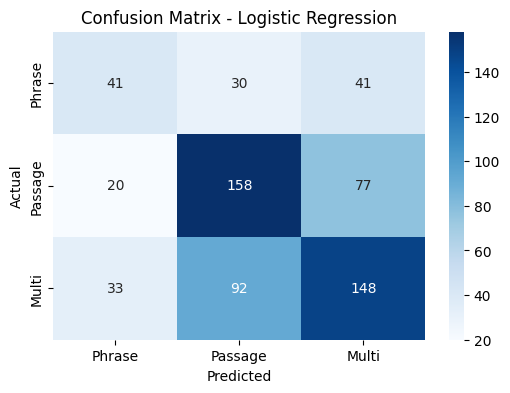

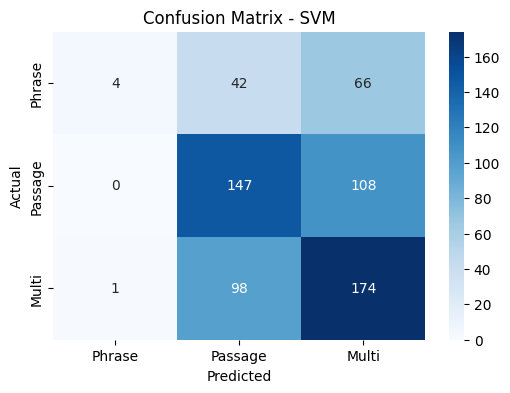

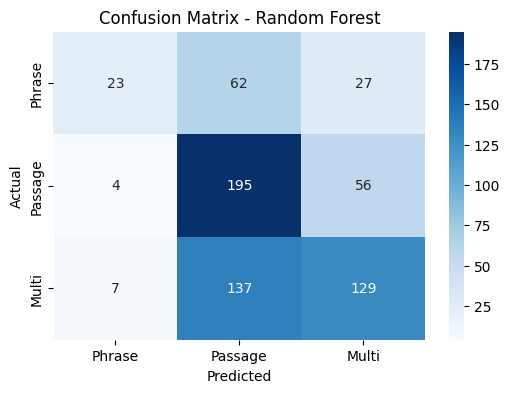

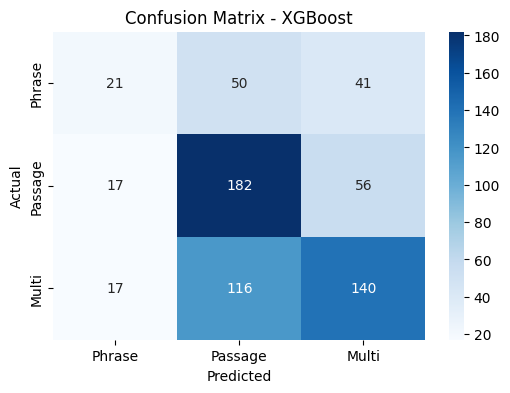

In [ ]:
ml_models = {
    "Logistic Regression": LogisticRegression(),
    "SVM": SVC(),
    "Random Forest": RandomForestClassifier(),

    "XGBoost": XGBClassifier(n_estimators=200, learning_rate=0.1, random_state=42)
}

# Test each model and collect performance metrics
results = {}

for name, model in ml_models.items():

  model.fit(x_train, y_train)             # It is to train on our training data

  predictions = model.predict(x_test)         # It is for making predictions on test data

  # Calculate accuracy
  accuracy = accuracy_score(y_test, predictions)
  report = classification_report(y_test, predictions)
  plot_confusion_matrix(y_test, predictions, name)
  results[name] = {
      "Accuracy": accuracy,
      "Classification Report": report
  }


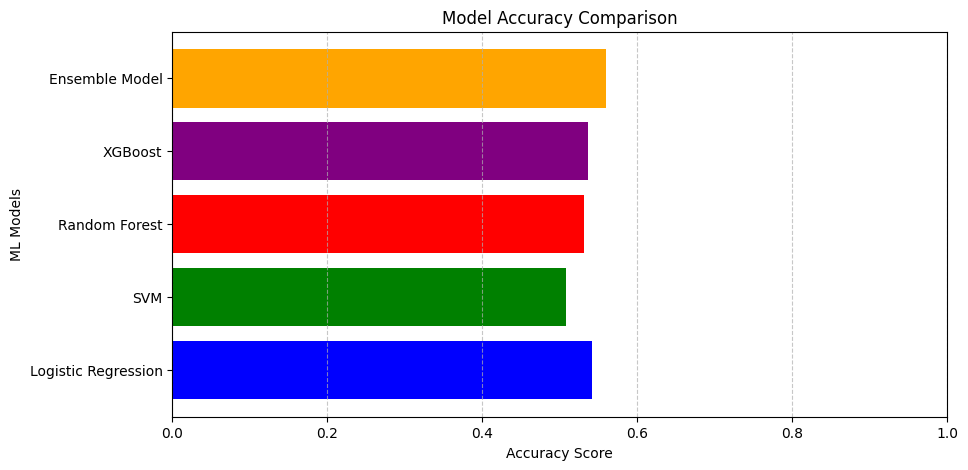

Logistic Regression:
Accuracy: 0.5422
Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.37      0.40       112
           1       0.56      0.62      0.59       255
           2       0.56      0.54      0.55       273

    accuracy                           0.54       640
   macro avg       0.52      0.51      0.51       640
weighted avg       0.54      0.54      0.54       640


--------------------------------------------------
SVM:
Accuracy: 0.5078
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.04      0.07       112
           1       0.51      0.58      0.54       255
           2       0.50      0.64      0.56       273

    accuracy                           0.51       640
   macro avg       0.60      0.42      0.39       640
weighted avg       0.56      0.51      0.47       640


--------------------------------------------------
Random Forest:
Accuracy: 0.5

In [ ]:
# Show how well each of our model performed with ensemble model (Voting Classifier with all models)

ensemble_model = VotingClassifier(estimators=[
    ('lr', LogisticRegression()),
    ('svm', SVC(probability = True)),
    ('rf', RandomForestClassifier(n_estimators = 2000)),

    ('xgb', XGBClassifier(n_estimators=200, learning_rate=0.1))
],voting = "soft")        # Soft voting averages probabilities for better performance

# Train the ensemble model
ensemble_model.fit(x_train, y_train)

# Make predictions using the ensemble model
ensemble_predictions = ensemble_model.predict(x_test)

# Calculate accuracy and store results
ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)
ensemble_report = classification_report(y_test, ensemble_predictions)

# Add results to the dictionary
results["Ensemble Model"] = {
    "Accuracy": ensemble_accuracy,
    "Classification Report": ensemble_report
}


# Extract model names and accuracies
model_names = list(results.keys())
accuracies = [results[model]["Accuracy"] for model in model_names]

# Plot accuracy comparison
plt.figure(figsize=(10, 5))
plt.barh(model_names, accuracies, color=['blue', 'green', 'red', 'purple', 'orange'])
plt.xlabel("Accuracy Score")
plt.ylabel("ML Models")
plt.title("Model Accuracy Comparison")
plt.xlim(0, 1)  # Accuracy ranges from 0 to 1
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()
# Print results for all the models

for model_name, metrics in results.items():
  print(f"{model_name}:")
  print(f"Accuracy: {metrics['Accuracy']:.4f}")
  print(f"Classification Report:\n{metrics['Classification Report']}\n")
  print("-" * 50)

In [ ]:
y_test

,encoded_tags
2001,2
1584,0
1136,1
2903,1
1334,2
...,...
2943,1
32,2
9,0
2270,2


In [ ]:
results[model_name]["Classification Report"]

'              precision    recall  f1-score   support\n\n           0       0.44      0.37      0.40       112\n           1       0.56      0.62      0.59       255\n           2       0.56      0.54      0.55       273\n\n    accuracy                           0.54       640\n   macro avg       0.52      0.51      0.51       640\nweighted avg       0.54      0.54      0.54       640\n'

In [ ]:
def plot_confusion_matrix(y_true, y_pred, model):
    confusion_matrix_= confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(confusion_matrix_, annot=True, fmt="d", cmap="Blues", xticklabels=['Phrase', 'Passage', 'Multi'], yticklabels=['Phrase', 'Passage', 'Multi'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {model}")
    plt.show()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Phrase', 'Passage', 'Multi'], yticklabels=['Phrase', 'Passage', 'Multi'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {LogisticRegression()}")
    plt.show()